In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

tf.config.threading.set_intra_op_parallelism_threads(64)
tf.config.threading.set_inter_op_parallelism_threads(64)

# Load the data
X = pd.read_csv('x_imputed.csv')
y = pd.read_csv('response.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include="number")  # Remove 'statecounty'

# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include='number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2)

In [10]:
#y_train = y_train.fillna(y_train.mean())

In [11]:
X

,"airpollutant:_1,3-butadiene_ug_m^3_epa2018",airpollutant:_acetaldehyde_ug_m^3_epa2017,airpollutant:_acetaldehyde_ug_m^3_epa2018,airpollutant:_benzene_ug_m^3_epa2017,airpollutant:_benzene_ug_m^3_epa2018,airpollutant:_carbon_tetrachloride_ug_m^3_epa2017,airpollutant:_carbon_tetrachloride_ug_m^3_epa2018,airpollutant:_formaldehyde_ug_m^3_epa2017,airpollutant:_formaldehyde_ug_m^3_epa2018,total_population_16yr_and_over_for_work_commute_acs2017_21,...,percent_of_farmers_market_accept_snap_usda_2018,number_of_farmers_market_accept_wic_usda_2018,percent_of_farmers_market_accept_wic_usda_2018,number_of_farmers_market_accept_wic_cash_usda_2018,number_of_farmers_market_accept_sfmnp_usda_2018,percent_of_farmers_market_accept_sfmnp_usda_2018,number_of_recreation_fitness_facilities_per1000_residents_usda_2016,populations_vulnerable_to_predicted_surface_smoke_from_wildland_fires_noaa2020,number_of_hospitals_county_cdcnehtracking_2020,number_of_pharmacies_available_per100000_cdcnehtracking_2016_20
0,0.01,1.50,1.41,0.19,0.18,0.51,0.37,1.84,1.69,25204.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,6.0,59759.0,1.0,11.90
1,0.01,1.15,1.10,0.17,0.16,0.51,0.37,1.47,1.40,94637.0,...,0.000000,0.0,0.0,0.0,4.0,100.0,21.0,246435.0,4.0,15.00
2,0.02,1.51,1.39,0.18,0.17,0.50,0.37,1.83,1.64,8324.0,...,50.000000,0.0,0.0,0.0,2.0,50.0,0.0,24706.0,1.0,15.90
3,0.01,1.61,1.54,0.18,0.18,0.51,0.37,1.90,1.86,7626.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,22005.0,1.0,18.00
4,0.01,1.24,1.19,0.20,0.19,0.50,0.37,1.65,1.59,23240.0,...,0.000000,1.0,100.0,0.0,1.0,100.0,4.0,59512.0,1.0,18.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138,0.00,0.32,0.29,0.10,0.10,0.42,0.31,0.51,0.49,20061.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,6.0,41345.0,2.0,11.90
3139,0.00,0.37,0.30,0.07,0.07,0.41,0.30,0.45,0.42,12795.0,...,33.333332,0.0,0.0,0.0,0.0,0.0,13.0,23287.0,1.0,17.36
3140,0.00,0.30,0.27,0.08,0.08,0.41,0.30,0.50,0.48,9236.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,2.0,20712.0,2.0,17.49
3141,0.00,0.41,0.34,0.09,0.10,0.45,0.33,0.54,0.50,3715.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,7719.0,1.0,42.88


In [12]:
print(X_train.isnull().sum())
print(X_train.isin([np.inf, -np.inf]).sum())
print(y_train.isnull().sum())


airpollutant:_1,3-butadiene_ug_m^3_epa2018                                        0
airpollutant:_acetaldehyde_ug_m^3_epa2017                                         0
airpollutant:_acetaldehyde_ug_m^3_epa2018                                         0
airpollutant:_benzene_ug_m^3_epa2017                                              0
airpollutant:_benzene_ug_m^3_epa2018                                              0
                                                                                 ..
percent_of_farmers_market_accept_sfmnp_usda_2018                                  0
number_of_recreation_fitness_facilities_per1000_residents_usda_2016               0
populations_vulnerable_to_predicted_surface_smoke_from_wildland_fires_noaa2020    0
number_of_hospitals_county_cdcnehtracking_2020                                    0
number_of_pharmacies_available_per100000_cdcnehtracking_2016_20                   0
Length: 1214, dtype: int64
airpollutant:_1,3-butadiene_ug_m^3_epa2018       

In [13]:
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    diff = tf.boolean_mask(y_true - y_pred, mask)  # Ignore NaNs
    return tf.reduce_mean(tf.square(diff))

def build_model(hp):
    model = tf.keras.models.Sequential()
    input_dim = X_train.shape[1]  # Ensure correct input dimension
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 2, 3)):  # Between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Adjust range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    # Output layer matching y_train shape
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))

    # Compile model with masked loss
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss=masked_loss,
                  metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [14]:
# tuner.results_summary()


In [15]:

# shap graph starts
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64, verbose = 1)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

Trial 20 Complete [00h 00m 17s]
val_mae: 22.673078536987305

Best val_mae So Far: 22.16053009033203
Total elapsed time: 00h 05m 38s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1148.7563 - mae: 25.7733 


Best Model Test Loss: 1121.51416015625, Test MAE: 25.19197654724121


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mse = mean_squared_error(X_test, y_test)
mae = mean_absolute_error(X_test, y_testd)
r2 = r2_score(X_test, y_testd)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


ValueError: y_true and y_pred have different number of output (1214!=1)

In [16]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)
assert list(X_train.columns) == list(X_test.columns), "Mismatch in feature columns"


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Swapping PermutationExplainer for GradientExplainer
X_train_np = X_train.values  # Convert X_train to NumPy array
X_test_np = X_test.values    # Convert X_test to NumPy array

# Initialize GradientExplainer
explainer = shap.GradientExplainer(best_model, X_train_np)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_np)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(629, 1214))']
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 1214))']
  warnings.warn(msg)


In [18]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(629, 1214, 1)


In [19]:
shap_values = np.squeeze(shap_values)  

import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
                                                feature  importance
1197  amount_of_snap_redemption_per_snap_authorized_...    3.695540
120   healthstatus_percent_pop_mental_health_not_goo...    3.102533
1167  percentage_female_ages_65_74_received_annual_m...    3.073377
829    community_resilience_national_percentile_nri2020    2.656564
1162  index_for_environment_with_access_to_healthy_f...    2.559524
...                                                 ...         ...
716   nhpi_single_race_households_have_1_or_more_iss...    0.017706
796   nhpi_single_race_civilian_population_65yrs_and...    0.008893
477   nhpi_single_race_female_65yrs_and_over_in_labo...    0.007413
795   nhpi_single_race_civilian_noninstitutionalized...    0.007135
980      wildfire_historic_loss_ratio_buildings_nri2020    0.000000

[1214 rows x 2 columns]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


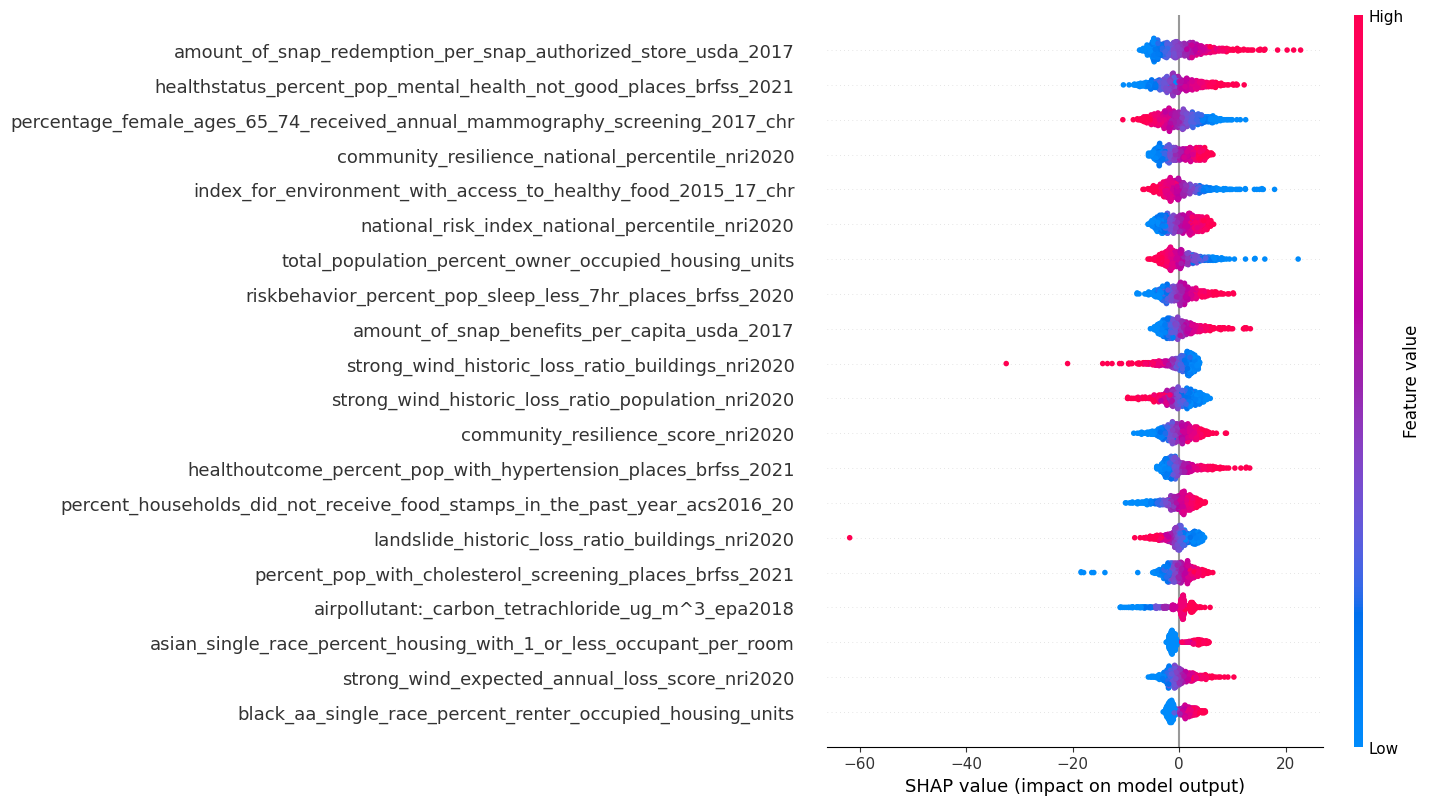

In [20]:
import shap
shap.summary_plot(shap_values, X_test, max_display=20)  # Adjust max_display as needed
